### Notebook 2 - 

When the virtual machine broken, I elected to finish the assignment requirment using a windows based machine.  It was not possible to extract the dataset from hadoop to continue to analysis so I elected to use the same dataset extacted using python.

The shape of the data is the same as the in extracted in Hadoop.

In [1]:
import pandas as pd 
import numpy as np
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# import the csv file filtered on weather

df = pd.read_csv('weather.csv')

In [3]:
# look at the of the dataframe

df.shape


(10532, 6)

In [4]:
# convert the full date column to a date column

df['date'] = pd.to_datetime(df['date'])
df['date_extract'] = df['date'].dt.date


In [5]:
# extract the time  from the date column

# Assuming your DataFrame is named 'df' and the date column is named 'date_column'
df['date'] = pd.to_datetime(df['date'])
df['time_extract'] = df['date'].dt.time

In [6]:
df.head()


,target,id,date,query,author,tweet,date_extract,time_extract
0,0,1467841885,2009-04-06 22:27:56,NO_QUERY,MissPassion,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06,22:27:56
1,0,1467912333,2009-04-06 22:46:44,NO_QUERY,Meg_Andruschak,@Steve_Buscemi the weather in Canada is freezing,2009-04-06,22:46:44
2,0,1467931501,2009-04-06 22:52:13,NO_QUERY,soulonfire68,We've been good. I'm not liking the snow right...,2009-04-06,22:52:13
3,0,1467960481,2009-04-06 23:00:26,NO_QUERY,breedimetria,@JessDubb lmao. U may have to wait for another...,2009-04-06,23:00:26
4,0,1468023365,2009-04-06 23:18:38,NO_QUERY,addictedtotext,it's going to be nice again tomorrow and then ...,2009-04-06,23:18:38


### Data Processing

#### Reference
1. https://medium.com/towards-data-science/another-twitter-sentiment-analysis-bb5b01ebad90
2. https://wblillyman.medium.com/real-world-example-of-data-scraping-cleaning-with-python-and-beautifulsoup-74e42e7936fe
3. 

In [7]:
# drop unnecessary columns 

df.drop(['id','date','query','author'],axis=1,inplace=True)

In [8]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [9]:
# removing @ symbols
pat1 = r'@[A-Za-z0-9_]+'
# removing weblinks
pat2 = r'https?://[^ ]+'

combined_pat = r'|'.join((pat1, pat2))
# updated web site listing
www_pat = r'www.[^ ]+'

# negative words that should not be updated or removed
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


In [10]:
# remove noise such as html links, stop words / punctuation / #hashtags etc

def tweet_cleaner(text):
    # remove any HTLM references
    soup = BeautifulSoup(text, 'lxml')
    # create a new var called souped
    souped = soup.get_text()
    # removing @
    stripped = re.sub(combined_pat, '', souped)
    try:
        # ensure all texted is in the utf-8 format
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)

    # convert all text to lowercase only
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    
    # remove any url links 
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    
    # removes any white space using tokenize to join together text and then 
    # removing any resulting white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
   
    return (" ".join(words)).strip()


In [11]:
# Apply the function to the 'tweet' column and create a new column 'Processed_tweets'

start_index = 0
end_index = 10532

clean_tweet_texts = []

for i in range(start_index, end_index):
    if (i + 1) % end_index == start_index:
        print("Tweets %d of %d have been processed" % (i + 1, end_index))

    clean_tweet_texts.append(tweet_cleaner(df['tweet'][i]))

Tweets 10532 of 10532 have been processed


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   target        10532 non-null  int64 
 1   tweet         10532 non-null  object
 2   date_extract  10532 non-null  object
 3   time_extract  10532 non-null  object
dtypes: int64(1), object(3)
memory usage: 329.2+ KB


In [13]:
df.head()

,target,tweet,date_extract,time_extract
0,0,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06,22:27:56
1,0,@Steve_Buscemi the weather in Canada is freezing,2009-04-06,22:46:44
2,0,We've been good. I'm not liking the snow right...,2009-04-06,22:52:13
3,0,@JessDubb lmao. U may have to wait for another...,2009-04-06,23:00:26
4,0,it's going to be nice again tomorrow and then ...,2009-04-06,23:18:38


In [14]:
# add a new column for the length of the text in the tweet column

df['tweet_len'] = [len(t) for t in df.tweet]

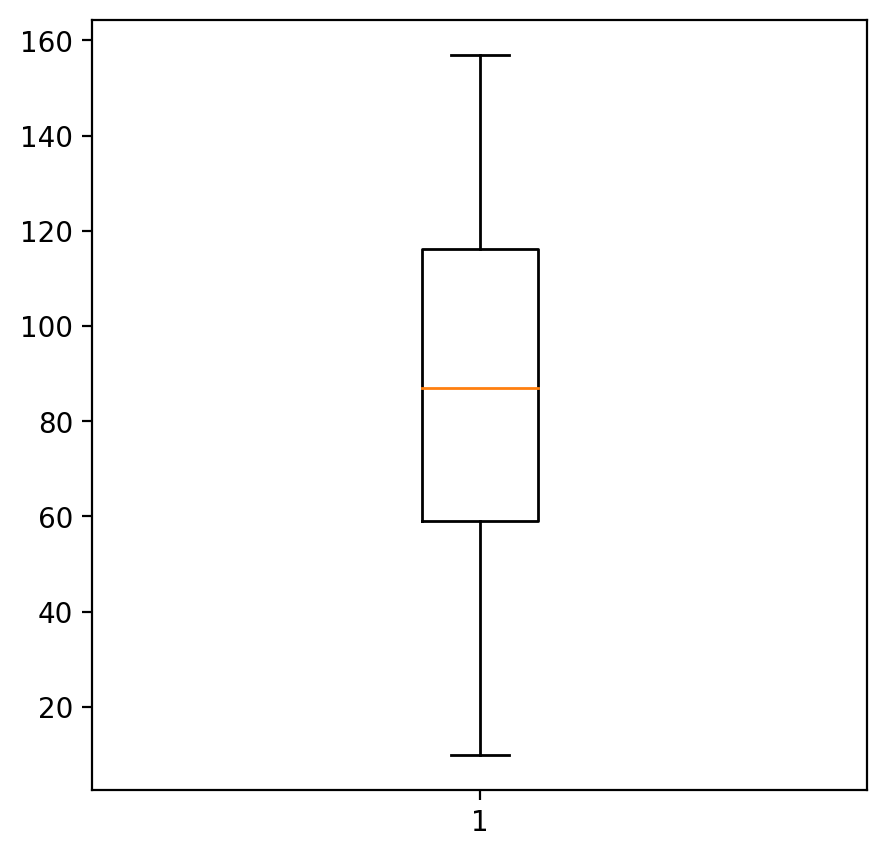

In [15]:
# look at the shape of the data

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.tweet_len)
plt.show()

In [16]:
# check for null values

null_values_count = null_values.any().any()

print("Null value counts:", null_values_count)

NameError: name 'null_values' is not defined

In [ ]:
# check for duplicate data
duplicates = df.duplicated()

# count the values
duplicate_count = duplicates.sum()

print("Duplicate count:", duplicate_count)

In [ ]:
# drop the resulting duplicates

df.drop_duplicates(inplace=True)

In [ ]:
# sort values by date order

df = df.sort_values(by='date_extract')

### Sentiment Analysis with TextBlob

TextBlob - common text processing operation, allowing NLP with an easy to use interface. uses sentiment analysis, parsing etc.


#### Reference

1. https://textblob.readthedocs.io/en/dev/quickstart.html
2. https://textblob.readthedocs.io/en/dev/quickstart.html?highlight=natural%20sentiment#sentiment-analysis
3. https://medium.com/towards-data-science/covid-19-vaccine-whats-the-public-sentiment-7149c9b42b99#29b2
4. https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/

In [ ]:
from textblob import TextBlob

In [ ]:
# Obtain sentiment scores generated by TextBlob

df['textblob_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
# review the new textblob score

# df.head()

In [ ]:
# Set threshold to define neutral sentiment 
# a score greate than 0.05 is positive, 0 to 0.05 is Neutral and less than 1 is negative

neutral_thresh = 0.05

In [ ]:
# Convert polarity score into sentiment categories

df['textblob_sentiment'] = df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [ ]:
df.head()

In [ ]:
# Plot the sentiment scores

sns.set()

plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=1000)
plt.plot(df.index, df['textblob_sentiment'])

plt.show()

#### Time Series Analysis 

##### References
1. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
2. https://medium.com/towards-data-science/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
3. ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
4. ARIMA - https://medium.com/towards-data-science/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7


In [19]:
df.head()

,target,tweet,date_extract,time_extract,tweet_len
0,0,@thecoolestout Ehhh don't. Weather's gonna tak...,2009-04-06,22:27:56,77
1,0,@Steve_Buscemi the weather in Canada is freezing,2009-04-06,22:46:44,49
2,0,We've been good. I'm not liking the snow right...,2009-04-06,22:52:13,117
3,0,@JessDubb lmao. U may have to wait for another...,2009-04-06,23:00:26,106
4,0,it's going to be nice again tomorrow and then ...,2009-04-06,23:18:38,99


In [20]:
# Divide the data set into test and train

# create a new df based on date which is less than 
train = df[df.date_extract <= pd.to_datetime("2009-04-30", format='%Y-%m-%d')]

# create a new df where the date is greater than or equal to 01 May
test = df[df.date_extract >= pd.to_datetime("2009-05-01", format='%Y-%m-%d')]
